Start date of trip: 2018-10-01
End date of trip: 2018-10-15

##### Precipitation Analysis #####

In [87]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import func
from pprint import pprint
import datetime as dt
import pandas as pd

In [52]:
#connect to hawaii.sqlite database
engine = create_engine("sqlite:///hawaii.sqlite")

In [53]:
conn = engine.connect()
conn.execute("select * from measurement limit 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [54]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id BIGINT
station TEXT
date TEXT
prcp FLOAT
tobs BIGINT


In [55]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(conn, reflect=True)

# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [56]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [57]:
# Start a session to query the database
session = Session(engine)

In [59]:
#Get the latest date 
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

latest_date

('2017-08-23')

In [60]:
#12 months before latest date
date = dt.date(2017,8,23) - dt.timedelta(days=360)
date

datetime.date(2016, 8, 28)

In [61]:
#Design a query to retrieve the last 12 months of precipitation data.
#Select only the `date` and `prcp` values.

stmt = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= date).\
        order_by(Measurement.date.desc()).statement

In [122]:
#Load the query results into a Pandas DataFrame and set the index to the date column.

df2 = pd.read_sql_query(stmt, session.bind)
df2.head(20)

,date,prcp
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00
5,2017-08-22,0.00
6,2017-08-22,0.50
7,2017-08-21,0.00
8,2017-08-21,0.02
9,2017-08-21,0.56


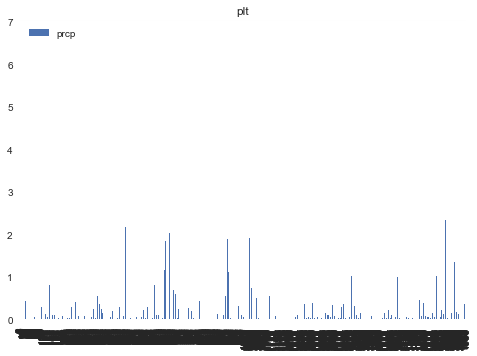

In [123]:
#Plot the results using the DataFrame `plot` method.
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df2.plot.bar(title="plt")
plt.show()

In [68]:
#summary statistics for precipitation data
df2.describe()

,prcp
count,1991.000000
mean,0.173420
std,0.454679
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


##### Station Analysis #####

In [69]:
session.new

IdentitySet([])

In [71]:
#Find total number of stations
stations = session.query(Station.name).count()
print("There are {} stations".format(stations))

There are 9 stations


In [97]:
#Design a query to find the most active stations.
# sel = [Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs, 
#       Station.station, Station.name]
# same_station = session.query(*sel).filter(Measurement.station == Station.station)

stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).\
        limit(1).all()
print(f"The most active station is {stations[0][0]}")                                                                                    

The most active station is USC00519281


In [99]:
#List the stations and observation counts in descending order
stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
        
pprint(stations)        

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]


In [108]:
#Design a query to retrieve the last 12 months of temperature observation data data.

stmt_tobs = session.query(Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').\
        filter(Measurement.date >= date).\
        order_by(Measurement.date.desc()).statement

In [120]:
df_tobs = pd.read_sql_query(stmt_tobs, session.bind)
df_tobs.head(20)

,tobs
0,79
1,76
2,76
3,77
4,77
5,77
6,83
7,82
8,77
9,76


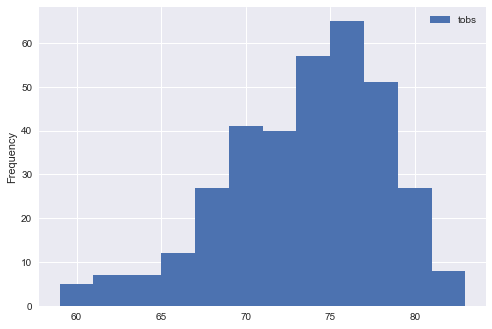

In [149]:
#Plot the results as a histogram with `bins=12`
df_tobs.plot.hist(bins=12)

##### Temperature Analysis #####

In [200]:
# Write a function called `calc_temps` that will accept a start date and end date in 
# the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.
from sqlalchemy import and_

def calc_temps(start_date, end_date): 
    
    start_date = func.strftime("%Y-%m-%d", start_date)
    end_date = func.strftime("%Y-%m-%d", end_date)

    sel = [func.avg(Measurement.tobs),
           func.max(Measurement.tobs),
           func.min(Measurement.tobs)]
    
    stats = session.query(*sel).\
          filter(and_(Measurement.date >= start_date, Measurement.date <= end_date)).all()

    return stats
#     func.max(Measurement.tobs), func.min(Measurement.tobs))

In [213]:
#Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip 
#using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
trip_stats = calc_temps('2016-10-01', '2017-10-01')
print(trip_stats)


[(74.08802228412256, 87, 58)]


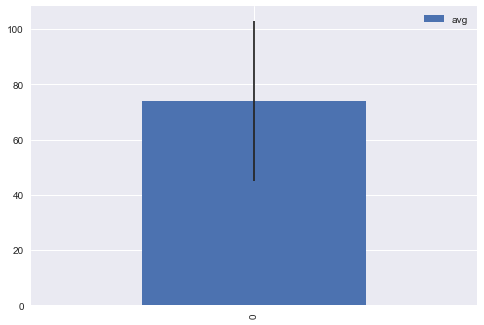

In [249]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
import numpy as np
import matplotlib.pyplot as plt

trip_stats = list(np.ravel(trip_stats))

average = trip_stats[0]
max_tobs = trip_stats[1]
min_tobs = trip_stats[2]

yerror = [max_tobs - min_tobs]

df = pd.DataFrame({'avg': [average]}, index=[0])

df.plot(kind='bar', yerr=yerror)

plt.show()


#### Climate App #####